# Distributed MNIST with MLX and Kubeflow Trainer

This Notebook will show how to run distributed MLX on Kubernetes with Kubeflow Trainer.

The MLX runtime uses `mlx[cuda]` package to run distributed training on GPUs.

MLX Distributed: https://ml-explore.github.io/mlx/build/html/usage/distributed.html

## Install the Kubeflow SDK

You need to install the Kubeflow SDK to interact with Kubeflow Trainer APIs:

In [ ]:
# !pip install -U kubeflow

## Install the MLX Dependencies

You also need to install MLX packages to evaluate the trained model.

In [ ]:
!pip install "mlx>=0.28.0"
!pip install "mlx-data>=0.1.0"
!pip install "matplotlib>=3.10.5"

## Update the GPU Resources

Currently, Kubeflow Trainer does not support configuring MLX resources directly through a
TrainJob specification.

To adjust GPU allocations (and other container resource settings), you must manually patch the ClusterTrainingRuntime.

Progress for native resource configuration in TrainJob is being tracked here: [kubeflow/trainer#2650](https://github.com/kubeflow/trainer/issues/2650)


In [1]:
patch = """
[
  {
    "op": "add",
    "path": "/spec/template/spec/replicatedJobs/0/template/spec/template/spec/containers/0/resources",
    "value": { "limits": { "nvidia.com/gpu": "1" } }
  },
  {
    "op": "add",
    "path": "/spec/template/spec/replicatedJobs/1/template/spec/template/spec/containers/0/resources",
    "value": { "limits": { "nvidia.com/gpu": "1" } }
  }
]
"""
!kubectl patch clustertrainingruntime mlx-distributed --type='json' -p "$patch"

clustertrainingruntime.trainer.kubeflow.org/mlx-distributed patched


## Create MLX training script

We need to wrap our training script into a function to create Kubeflow TrainJob.

This is the simple MLP model to recognize digits from the MNIST dataset.

In [ ]:
def mlx_train_mnist(bucket: str, model_name: str):
    import time
    from functools import partial
    import mlx.core as mx
    import mlx.nn as nn
    import mlx.optimizers as optim
    from mlx.data.datasets import load_mnist
    import boto3


    # Define a simple MLP model with MLX.
    class MLP(nn.Module):
        def __init__(
            self, in_dims: int, hidden_dims: int, num_layers: int, out_dims: int
        ):
            super().__init__()
            layer_sizes = [in_dims] + [hidden_dims] * num_layers + [out_dims]
            self.layers = [
                nn.Linear(idim, odim)
                for idim, odim in zip(layer_sizes[:-1], layer_sizes[1:])
            ]

        def __call__(self, x):
            for layer in self.layers[:-1]:
                x = nn.relu(layer(x))
            return self.layers[-1](x)

    # Initializer MLX distributed backend.
    dist = mx.distributed.init(strict=True, backend="mpi")
    world_size = dist.size()
    rank = dist.rank()
    print(f"Start Distributed Training, WORLD_SIZE: {world_size}, RANK: {rank}")

    if rank == 0:
        print("Download MNIST dataset")

    # Load MNIST dataset and partition it.
    BATCH_SIZE = 128
    train_dataset = load_mnist()

    distributed_ds = (
        train_dataset.shuffle()
        .partition_if(world_size > 1, world_size, rank)
        .key_transform("image", lambda x: (x.astype("float32") / 255.0).ravel())
    )

    # Create the MLP model and SGD optimizer
    model = MLP(
        in_dims=distributed_ds[0]["image"].shape[-1],
        hidden_dims=32,
        num_layers=2,
        out_dims=10,
    )
    optimizer = optim.SGD(learning_rate=0.01)

    # Define function to calculate loss and accuracy.
    def loss_fn(model, x, y):
        output = model(x)
        loss = mx.mean(nn.losses.cross_entropy(output, y))
        acc = mx.mean(mx.argmax(output, axis=1) == y)
        return loss, acc

    # Define single training step.
    @partial(mx.compile, inputs=model.state, outputs=model.state)
    def step(x, y):
        loss_and_grad_fn = nn.value_and_grad(model, loss_fn)
        (loss, acc), grads = loss_and_grad_fn(model, x, y)
        # Average grads to aggregate them across distributed nodes.
        grads = nn.utils.average_gradients(grads)
        optimizer.update(model, grads)
        return loss, acc

    # Average statistic across distributed nodes.
    def average_stats(stats, count):
        with mx.stream(mx.cpu):
            stats = mx.distributed.all_sum(mx.array(stats))
            count = mx.distributed.all_sum(count)
            return (stats / count).tolist()

    # Start distributed training.
    if rank == 0:
        print("Start MLX training")
    for epoch in range(15):
        epoch_start = time.perf_counter()
        losses = accuracies = count = 0

        for batch_idx, batch_sample in enumerate(distributed_ds.batch(BATCH_SIZE)):
            x = mx.array(batch_sample["image"])
            y = mx.array(batch_sample["label"])
            loss, acc = step(x, y)
            mx.eval(loss, acc, model.state)

            losses += loss.item()
            accuracies += acc.item()
            count += 1

            # Print the results.
            if batch_idx % 10 == 0:
                loss, acc = average_stats([losses, accuracies], count)
                if rank == 0:
                    print(
                        "Epoch: {} [{}/{} ({:.0f}%)] \tTrain loss: {:.3f}, acc: {:.3f}".format(
                            epoch,
                            batch_idx * len(x),
                            len(train_dataset),
                            100.0 * batch_idx * len(x) / len(train_dataset),
                            loss,
                            acc,
                        )
                    )
        if rank == 0:
            print(
                "Epoch: {}, time: {:.2f} seconds\n\n".format(
                    epoch, time.perf_counter() - epoch_start
                )
            )

    # Finally, export model to S3.
    if rank == 0:
        print("Exporting MNIST model to S3")
        model.save_weights(model_name)
        boto3.client("s3").upload_file(model_name, bucket, model_name)

## Get the MLX Runtime

You can list the available Kubeflow Trainer runtimes with the `list_runtimes()` API.

The name of MLX runtime is `mlx-distributed`.

In [6]:
from kubeflow.trainer import TrainerClient, CustomTrainer

for r in TrainerClient().list_runtimes():
    if r.name == "mlx-distributed":
        print(f"Name: {r.name}, Framework: {r.trainer.framework}, Trainer Type: {r.trainer.trainer_type.value}\n")
        mlx_runtime = r

Name: mlx-distributed, Framework: mlx, Trainer Type: CustomTrainer



## Create TrainJob for Distributed Training

Use the `train()` API to create distributed TrainJob on **3 GPUs**. Every MPI training node uses 1 GPU.

**Note:** Update the S3 bucket name.

In [3]:
# BUCKET = "Add your S3 bucket"
MODEL = "mnist.npz"

In [ ]:
args = {"bucket": BUCKET, "model_name": MODEL}

job_id = TrainerClient().train(
    trainer=CustomTrainer(
        func=mlx_train_mnist,
        func_args=args,
        num_nodes=3,
        packages_to_install=["boto3"],
    ),
    runtime=mlx_runtime,
)

In [12]:
# Train API generates a random TrainJob id.
job_id

'd2cd1310e282'

## Check the TrainJob Info

Use the `list_jobs()` and `get_job()` APIs to get information about created TrainJob and its steps.

In [13]:
for job in TrainerClient().list_jobs():
    print(f"TrainJob: {job.name}, Status: {job.status}, Created at: {job.creation_timestamp}")

TrainJob: d2cd1310e282, Status: Created, Created at: 2025-09-03 13:55:43+00:00


In [15]:
# We execute mpirun command on node-0, which functions as the MPI Launcher node.
for c in TrainerClient().get_job(name=job_id).steps:
    print(f"Step: {c.name}, Status: {c.status}, Devices: {c.device} x {c.device_count}\n")

Step: node-0, Status: Running, Devices: gpu x 1

Step: node-1, Status: Running, Devices: gpu x 1

Step: node-2, Status: Running, Devices: gpu x 1



## Get the TrainJob Logs

Use the `get_job_logs()` API to retrieve the TrainJob logs.

Since we distribute the dataset across 3 GPUs, each rank processes `round(60,000 / 3) = 20,000` samples.

In [17]:
for logline in TrainerClient().get_job_logs(job_id, follow=True):
    print(logline)

Start Distributed Training, WORLD_SIZE: 3, RANK: 0
Download MNIST dataset
Start Distributed Training, WORLD_SIZE: 3, RANK: 2
Start Distributed Training, WORLD_SIZE: 3, RANK: 1
Start MLX training
Epoch: 0 [0/60000 (0%)] 	Train loss: 2.299, acc: 0.117
Epoch: 0 [1280/60000 (2%)] 	Train loss: 2.304, acc: 0.108
Epoch: 0 [2560/60000 (4%)] 	Train loss: 2.303, acc: 0.110
Epoch: 0 [3840/60000 (6%)] 	Train loss: 2.302, acc: 0.112
Epoch: 0 [5120/60000 (9%)] 	Train loss: 2.301, acc: 0.117
Epoch: 0 [6400/60000 (11%)] 	Train loss: 2.300, acc: 0.122
Epoch: 0 [7680/60000 (13%)] 	Train loss: 2.300, acc: 0.125
Epoch: 0 [8960/60000 (15%)] 	Train loss: 2.299, acc: 0.130
Epoch: 0 [10240/60000 (17%)] 	Train loss: 2.298, acc: 0.135
Epoch: 0 [11520/60000 (19%)] 	Train loss: 2.297, acc: 0.138
Epoch: 0 [12800/60000 (21%)] 	Train loss: 2.297, acc: 0.142
Epoch: 0 [14080/60000 (23%)] 	Train loss: 2.296, acc: 0.146
Epoch: 0 [15360/60000 (26%)] 	Train loss: 2.295, acc: 0.150
Epoch: 0 [16640/60000 (28%)] 	Train loss:

## Evaluate the Trained Model

Download the trained model from S3 to evaluate it.

We will use test images from the MNIST dataset for prediction.

- <span style="color:green">Green label</span> indicate correct predictions.
- <span style="color:red">Red label</span> indicate incorrect predictions, with the correct value shown in parentheses.

In [4]:
import boto3

boto3.client("s3").download_file(BUCKET, MODEL, MODEL)

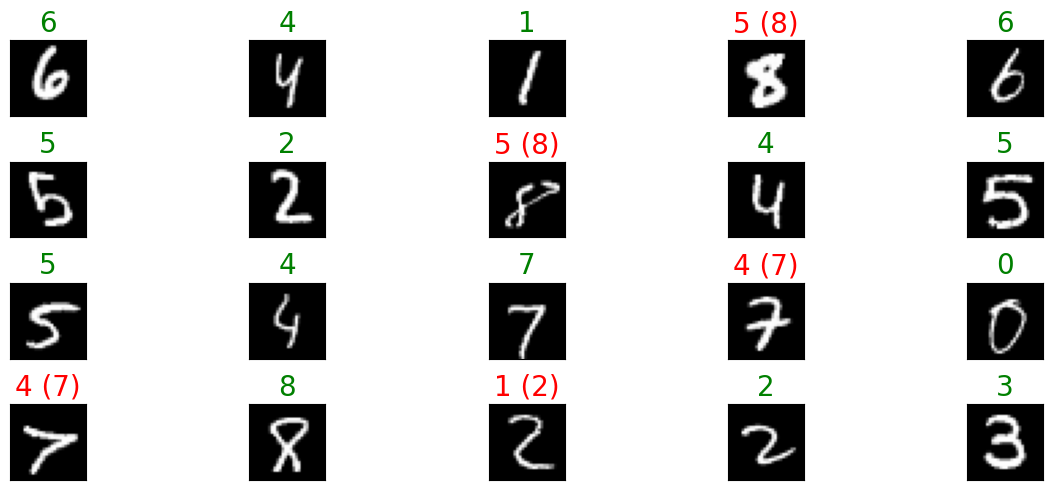

In [7]:
import mlx.core as mx
import mlx.nn as nn
import matplotlib.pyplot as plt
from mlx.data.datasets import load_mnist


# Load test dataset and take the random batch from it.
test_batch = (
    load_mnist(train=False)
    .key_transform("image", lambda x: (x.astype("float32") / 255.0).ravel())
    .batch(20)[mx.random.randint(10, 500)]
)

class MLP(nn.Module):
    def __init__(self, in_dims: int, hidden_dims: int, num_layers: int, out_dims: int):
        super().__init__()
        layer_sizes = [in_dims] + [hidden_dims] * num_layers + [out_dims]
        self.layers = [
            nn.Linear(idim, odim)
            for idim, odim in zip(layer_sizes[:-1], layer_sizes[1:])
        ]

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = nn.relu(layer(x))
        return self.layers[-1](x)

# Load weights from the trained model.
model = MLP(
    in_dims=test_batch["image"][0].shape[-1],
    hidden_dims=32,
    num_layers=2,
    out_dims=10,
).load_weights(MODEL)

# Send test batch to the pre-trained MLP model.
x = mx.array(test_batch["image"])
output = model(x)
fig = plt.figure(figsize=(15, 5))
for i in range(20):
    # Format the input image and the model output.
    image = test_batch["image"][i].reshape((28, 28))
    pred_label = mx.argmax(output[i])

    # Add data to the plot.
    ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(image, cmap="gray")
    if test_batch["label"][i] == pred_label:
        ax.set_title(test_batch["label"][i], color="green")
    else:
        ax.set_title("{} ({})".format(pred_label, test_batch["label"][i]), color="red")

    ax.title.set_fontsize(20)
    fig.tight_layout()

## Delete the TrainJob

When TrainJob is finished, you can delete the resource.

In [ ]:
TrainerClient().delete_job(job_id)